Src:
* [Siamese Networks Introduction and Implementation](https://towardsdatascience.com/siamese-networks-introduction-and-implementation-2140e3443dee)

In [60]:
import os
import sys
import random
from itertools import product
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from mpl_toolkits.mplot3d import Axes3D
import cv2
import tensorflow as tf
from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Lambda, dot
from keras.utils import plot_model
from keras.saving import register_keras_serializable
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import distance


In [61]:
!unzip shapes.zip

Archive:  shapes.zip
replace shapes/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: shapes/.DS_Store        
  inflating: shapes/circle/circle_blue0.png  
  inflating: shapes/circle/circle_blue1.png  
  inflating: shapes/circle/circle_blue10.png  
  inflating: shapes/circle/circle_blue100.png  
  inflating: shapes/circle/circle_blue101.png  
  inflating: shapes/circle/circle_blue102.png  
  inflating: shapes/circle/circle_blue103.png  
  inflating: shapes/circle/circle_blue104.png  
  inflating: shapes/circle/circle_blue105.png  
  inflating: shapes/circle/circle_blue106.png  
  inflating: shapes/circle/circle_blue107.png  
  inflating: shapes/circle/circle_blue108.png  
  inflating: shapes/circle/circle_blue109.png  
  inflating: shapes/circle/circle_blue11.png  
  inflating: shapes/circle/circle_blue110.png  
  inflating: shapes/circle/circle_blue111.png  
  inflating: shapes/circle/circle_blue112.png  
  inflating: shapes/circle/circle_blue113.png  
  inflating: shap

In [62]:
dir = os.getcwd()+"/shapes/"

images = []
y_col = []

for root, dirs, files in os.walk(dir, topdown=False):
    for name in files:
        fullname = os.path.join(root, name)
        if fullname.find(".png") != -1 :
            images.append(fullname)
            if fullname.find("red") != -1 :
                y_col.append(0)
            elif fullname.find("green") != -1 :
                y_col.append(1)
            else :
                y_col.append(2)

y_col = np.array(y_col)
images = np.array(images)

In [63]:
print (images)

['/content/shapes/rectangle/rectangle_blue96.png'
 '/content/shapes/rectangle/rectangle_green228.png'
 '/content/shapes/rectangle/rectangle_green474.png' ...
 '/content/shapes/circle/circle_red131.png'
 '/content/shapes/circle/circle_blue348.png'
 '/content/shapes/circle/circle_blue91.png']


In [64]:
print (y_col)

[2 1 1 ... 0 2 2]


In [65]:
red_im = images[np.where(y_col==0)]
green_im = images[np.where(y_col==1)]
blue_im = images[np.where(y_col==2)]

In [66]:
test_red_im = red_im[50:]
test_green_im = green_im[50:]
test_blue_im = blue_im[50:]

In [67]:
red_im = red_im[:20]
green_im = green_im[:20]
blue_im = blue_im[:20]

In [68]:
positive_red = list(itertools.combinations(red_im, 2))
positive_green = list(itertools.combinations(green_im, 2))
positive_blue = list(itertools.combinations(blue_im, 2))

In [69]:
negative1 = itertools.product(red_im,green_im)
negative1 = list(negative1)

negative2 = itertools.product(green_im,blue_im)
negative2 = list(negative2)

negative3 = itertools.product(red_im,blue_im)
negative3 = list(negative3)

In [70]:
positive_samples = positive_blue + positive_green + positive_red
negative_samples = negative1 + negative2 + negative3

In [71]:
color_X1 = []
color_X2 = []
color_y = []

for fname in positive_samples :
    im = cv2.imread(fname[0])
    color_X1.append(im)
    im = cv2.imread(fname[1])
    color_X2.append(im)
    color_y.append(1)

for fname in negative_samples :
    im = cv2.imread(fname[0])
    color_X1.append(im)
    im = cv2.imread(fname[1])
    color_X2.append(im)
    color_y.append(0)


color_y = np.array(color_y)
color_X1 = np.array(color_X1)
color_X2 = np.array(color_X2)
color_X1 = color_X1.reshape((len(negative_samples) + len(positive_samples), 28, 28, 3))
color_X2 = color_X2.reshape((len(negative_samples) + len(positive_samples), 28, 28, 3))

color_X1 = 1 - color_X1/255
color_X2 = 1 - color_X2/255

print("Color data : ", color_X1.shape, color_X2.shape, color_y.shape)

Color data :  (1770, 28, 28, 3) (1770, 28, 28, 3) (1770,)


In [72]:
@register_keras_serializable()
class L2NormalizationLayer(Layer):
    def call(self, inputs):
        return tf.nn.l2_normalize(inputs, axis=-1)

In [73]:
def train_color_encoder(X1, X2, y) :
    input_layer = Input((28, 28, 3))
    layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
    layer2 = MaxPooling2D((2, 2), padding='same')(layer1)
    layer3 = Conv2D(8, (3, 3), activation='relu', padding='same')(layer2)
    layer4 = MaxPooling2D((2, 2), padding='same')(layer3)
    layer5 = Flatten()(layer4)
    embeddings = Dense(16, activation=None)(layer5)
    # norm_embeddings = Lambda(lambda x: tf.nn.l2_normalize(x, axis=-1), output_shape=(16,))(embeddings)
    norm_embeddings = L2NormalizationLayer()(embeddings)

    model = Model(inputs=input_layer, outputs=norm_embeddings)

    input1 = Input((28,28,3))
    input2 = Input((28,28,3))

    left_model = model(input1)
    right_model = model(input2)

    dot_product = dot([left_model, right_model], axes=1, normalize=False)

    siamese_model = Model(inputs=[input1, input2], outputs=dot_product)

    print(siamese_model.summary())

    siamese_model.compile(optimizer='adam', loss= 'mse')

    plot_model(siamese_model, to_file=os.getcwd()+'/siamese_model_mnist.png', show_shapes=1, show_layer_names=1)

    siamese_model.fit([X1, X2], y, epochs=100, batch_size=5, shuffle=True, verbose=True)

    model.save(os.getcwd() + "/color_encoder.keras")
    siamese_model.save(os.getcwd() + "/color_siamese_model.keras")

    return model, siamese_model

In [74]:
train_color_encoder(color_X1, color_X2, color_y)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 28, 28, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_8             │ (None, 28, 28, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_4 (Functional) │ (None, 16)             │          7,896 │ input_layer_7[0][0],   │
│                           │                        │                │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_2 (Dot)               │ (None, 1)              │              0 │ functional_4[0][0],    │
│                           │                        │                │ functional_4[1][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,896 (30.84 KB)

 Trainable params: 7,896 (30.84 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0948
Epoch 2/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.0769e-04
Epoch 3/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 3.4248e-04
Epoch 4/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.9410e-04
Epoch 5/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.6002e-04
Epoch 6/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.1410e-04
Epoch 7/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 6.4134e-04
Epoch 8/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.2234e-04
Epoch 9/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 6.4825e-05
Epoch 10/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 1.8777e-04
Epoch 11/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.2350e-04
Epoch 12/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1.0344e-04
Epoch 13/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.2233e-04
Epoch 14/100
354/354 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step -

(<Functional name=functional_4, built=True>,
 <Functional name=functional_5, built=True>)

In [75]:
# keras.config.enable_unsafe_deserialization()
model = load_model(os.getcwd()+"/color_encoder.keras")
siamese_model = load_model(os.getcwd()+"/color_siamese_model.keras")

In [76]:
names = list(test_red_im) + list(test_green_im) + list(test_blue_im)
names1 = [x for x in names if 'red' in x]
names2 = [x for x in names if 'green' in x]
names3 = [x for x in names if 'blue' in x]

In [77]:
test_im = []
for i in range(len(names)) :
    test_im.append(cv2.imread(names[i]))

r,c,_ = test_im[0].shape
test_im = np.array(test_im)
test_im = test_im.reshape((len(test_im), r,c,3))
names = [x.split("/")[-1] for x in names]

test_im = 1 - test_im/255

In [78]:
pred = model.predict(test_im)

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [79]:
num = int(pred.shape[0]/3)
colors = ['red', 'blue', 'green']

y = [colors[0] for i in range(num)]
y += [colors[1] for i in range(num)]
y += [colors[2] for i in range(num)]

feat1 = pred[:,0]
feat2 = pred[:,1]
feat3 = pred[:,2]

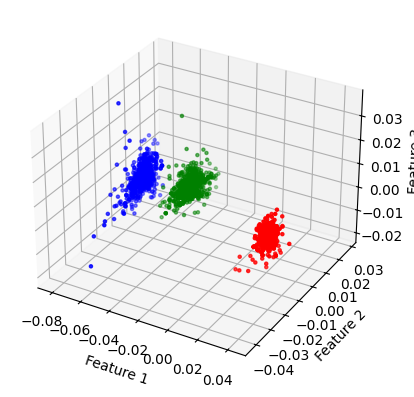

In [80]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

color_map = {'red': 'r', 'green': 'g', 'blue': 'b'}
mapped_colors = [color_map[color] for color in y]

ax.scatter(feat1, feat2, feat3, c=mapped_colors, marker='.')

ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

plt.show()


In [82]:
test_labels = ['red'] * len(test_red_im) + ['green'] * len(test_green_im) + ['blue'] * len(test_blue_im)

all_pairs = list(product(zip(test_im, test_labels), repeat=2))

sample_size = 1000
selected_pairs = random.sample(all_pairs, sample_size)

pair1 = np.array([pair[0][0] for pair in selected_pairs])
pair2 = np.array([pair[1][0] for pair in selected_pairs])
label1 = [pair[0][1] for pair in selected_pairs]
label2 = [pair[1][1] for pair in selected_pairs]

similarities = siamese_model.predict([pair1, pair2])

normalized_similarities = (similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))

print("Pairwise Similarities:")
for i, (norm_sim, lbl1, lbl2) in enumerate(zip(normalized_similarities, label1, label2)):
    same_color = "Same Color" if norm_sim > 0.5 else "Different Color"
    print(f"Pair {i + 1}: {lbl1} - {lbl2} => Similarity: {norm_sim[0]:.2f} ({same_color})")



32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Pairwise Similarities:
Pair 1: red - blue => Similarity: 0.01 (Different Color)
Pair 2: red - red => Similarity: 1.00 (Same Color)
Pair 3: green - red => Similarity: 0.01 (Different Color)
Pair 4: blue - green => Similarity: 0.01 (Different Color)
Pair 5: red - red => Similarity: 1.00 (Same Color)
Pair 6: red - blue => Similarity: 0.01 (Different Color)
Pair 7: blue - red => Similarity: 0.01 (Different Color)
Pair 8: blue - blue => Similarity: 1.00 (Same Color)
Pair 9: green - red => Similarity: 0.01 (Different Color)
Pair 10: red - red => Similarity: 1.00 (Same Color)
Pair 11: green - green => Similarity: 1.00 (Same Color)
Pair 12: red - green => Similarity: 0.01 (Different Color)
Pair 13: red - green => Similarity: 0.01 (Different Color)
Pair 14: red - red => Similarity: 1.00 (Same Color)
Pair 15: green - green => Similarity: 1.00 (Same Color)
Pair 16: green - blue => Similarity: 0.01 (Different Color)
Pair 17: green - red => Similarity: 0.01 (